In [224]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 

In [225]:
import tensorflow as tf
import tensorflow.keras

In [226]:
np.random.seed(1234)

## Problem

We have a dataset with all projects from Kickstarter for the last year. We want to understand what makes a project successful based on the data we have. 
- What are the reasons for a Kickstarter project to be successful?
- What are the characteris of a successful Kickstarter project?

## Read the data

In [227]:
data = pd.read_csv('data/ks-projects-201801.csv')

## Train-Test Split

Splitting the data into train and test data. For Validation it will be used cross-validation. **Stratiffied Shuffle Split.**

In [235]:
data_train, data_test = train_test_split(data, test_size=0.1, stratify=data["category"])

Checking whether the stratification by category is giving a good stratification by **main_category** and **state** as well. It seems everything is okay - all main categories are stratified around 90%

In [240]:
data_train["main_category"].value_counts() / data["main_category"].value_counts() * 100

Film & Video    90.003932
Music           90.003467
Publishing      89.998495
Games           89.997445
Technology      89.993552
Design          90.000000
Art             90.001066
Food            90.033331
Fashion         90.002630
Theater         89.947769
Comics          89.943618
Photography     90.008350
Crafts          90.021569
Journalism      90.010515
Dance           89.941614
Name: main_category, dtype: float64

In [246]:
data_train["state"].value_counts() / data["state"].value_counts() * 100

failed        90.051032
successful    89.954164
canceled      89.842440
undefined     90.174060
live          90.853876
suspended     89.490791
Name: state, dtype: float64

## Discover the data

In [241]:
data_train

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
268788,437827266,Vegan Antics - A 100% Vegan Bakery,Vegan,Food,GBP,2016-10-04,5000.0,2016-09-04 18:07:14,207.0,failed,13,GB,19.94,255.22,6164.70
172263,1876085348,The BRIM BAND Company,Accessories,Fashion,USD,2016-02-22,25000.0,2016-01-01 18:04:04,135.0,failed,2,US,135.00,135.00,25000.00
204609,2042318332,Pact Magic Unbound: Grimoire of Lost Souls for...,Tabletop Games,Games,USD,2015-03-28,2500.0,2015-02-26 12:41:38,9826.0,successful,242,US,9826.00,9826.00,2500.00
99083,1502985139,Cuvee 103 Bistro,Restaurants,Food,USD,2015-12-24,50000.0,2015-11-30 20:20:48,0.0,failed,0,US,0.00,0.00,50000.00
378274,998212114,Bizarre Noir * Pop Songs for Ugly People * alb...,Rock,Music,USD,2016-11-28,1200.0,2016-11-05 17:45:43,1420.0,successful,30,US,620.00,1420.00,1200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262660,40599481,Kids Are Awful (Canceled),Children's Books,Publishing,USD,2015-04-29,6500.0,2015-03-29 23:45:39,3067.0,canceled,46,US,3067.00,3067.00,6500.00
265446,420357420,"""Not Mother"": A Film About Kids, School, and A...",Shorts,Film & Video,USD,2011-01-10,2000.0,2010-12-09 03:27:26,2010.0,successful,26,US,2010.00,2010.00,2000.00
108102,1549582535,Ballin' From Grace,Music,Music,USD,2015-06-09,75000.0,2015-05-23 05:09:07,0.0,failed,0,US,0.00,0.00,75000.00
33761,1171444783,"""Creative Spirit"" - a film: Keith Medley's 27-...",Documentary,Film & Video,USD,2011-06-06,40000.0,2011-03-07 18:43:21,4696.0,failed,36,US,4696.00,4696.00,40000.00


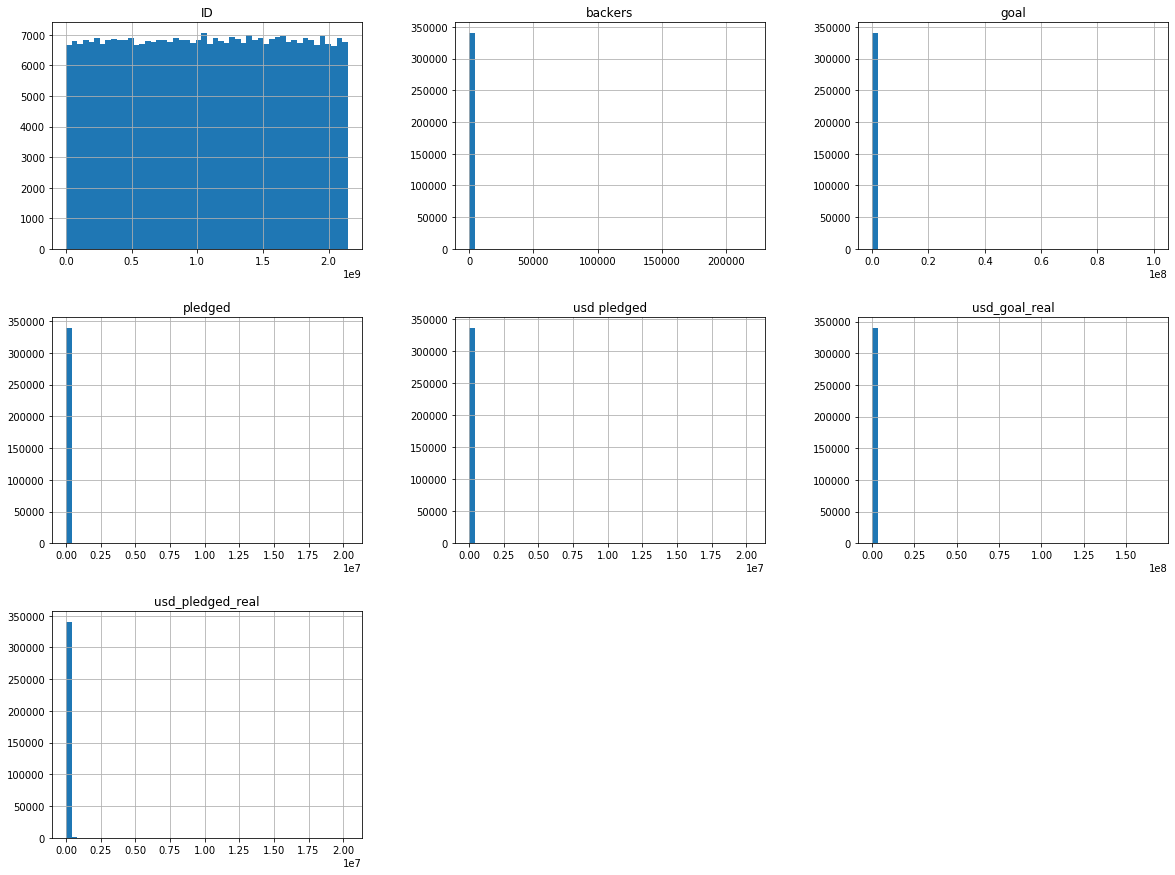

In [248]:
data_train.hist(bins=50, figsize=(20,15))
plt.show()

In [267]:
backers_log = np.log2(data_train["backers"])
backers_log[backers_log < 0]

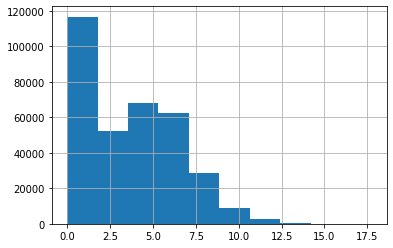

In [270]:
backers_log.hist()

### Display number of values of categorical features

Categorical features has to be one-hot encoded. Unfortunately, too many features will not help us with the model. It has to be decided which features to use.

In [163]:
categorical_features = data[['category', 'main_category', 'currency', 'country']]
for category in categorical_features:
    print(f'"{category}" has {len(categorical_features[category].value_counts())} values.')

"category" has 159 values.
"main_category" has 15 values.
"currency" has 14 values.
"country" has 23 values.


### Displaying the most successful and failed main_categories

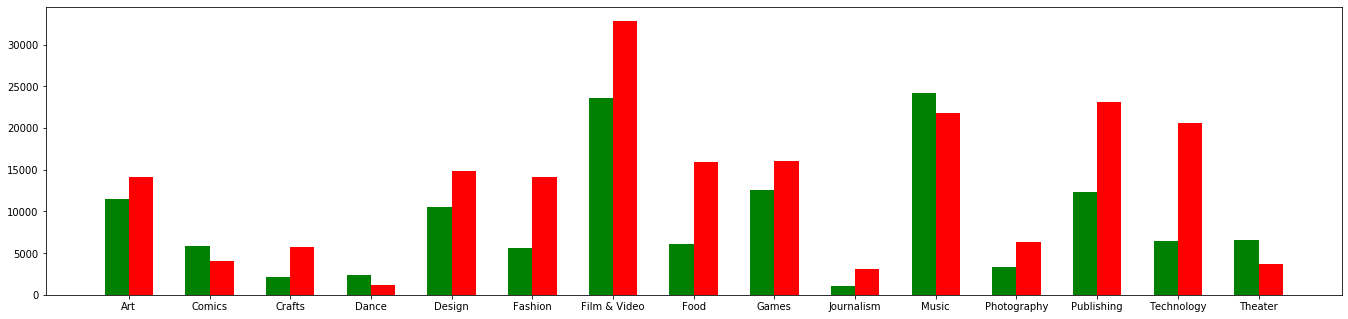

In [164]:
main_cats_sucess = data[data["state"] == "successful"]["main_category"].value_counts().sort_index()
main_cats_failed = data[data["state"] == "failed"]["main_category"].value_counts().sort_index()

fig = plt.figure()

ind = np.arange(len(main_cats_sucess)) 
width = 0.3

ax = fig.add_axes([0,0,3,1])
ax.bar(ind, list(main_cats_sucess.values), width = width, color = "g")
ax.bar(ind + width, list(main_cats_failed.values), width = width, color = "r")

plt.xticks(ind + width / 2, main_cats_sucess.index)

plt.show()

### Displaying the most successful and failed categories

<Figure size 72x144 with 0 Axes>

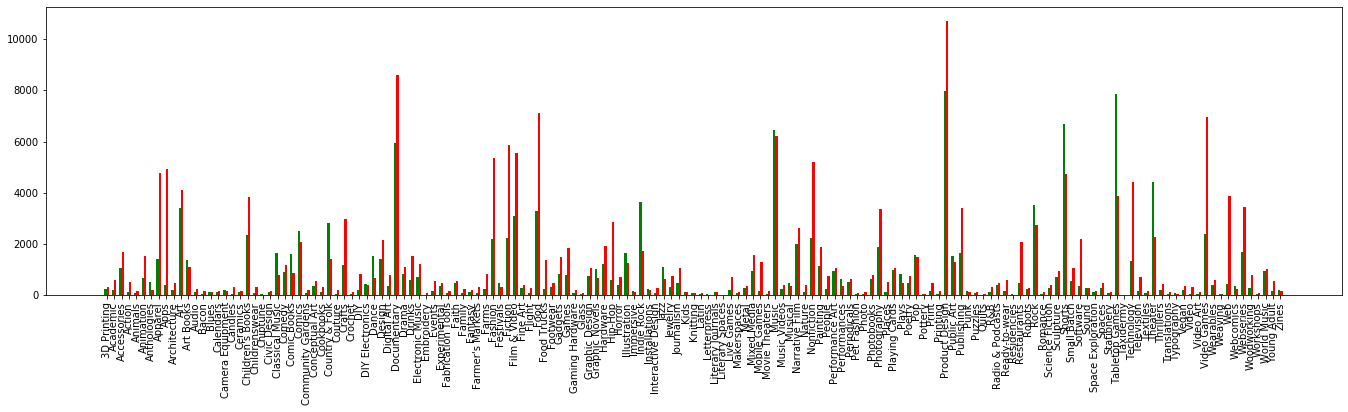

In [220]:
cats_sucess = data[data["state"] == "successful"]["category"].value_counts().sort_index()
cats_failed = data[data["state"] == "failed"]["category"].value_counts().sort_index()

fig = plt.figure()

ind = np.arange(len(cats_sucess)) 
width = 0.3

ax = fig.add_axes([0,0,3,1])
ax.bar(ind, list(cats_sucess.values), width = width, color = "g")
ax.bar(ind + width, list(cats_failed.values), width = width, color = "r")

plt.xticks(ind + width / 2, cats_sucess.index, rotation='vertical')

plt.show()

### Finding the most successful projects based on correlations

There is high correlation for **backers** and **pledged** money, which is normal. The correlations between categories are not strong. It can be seen that projects from US and with USD currency are most successful. 

In [221]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [165]:
dummies_corr = pd.get_dummies(data, columns = ["main_category", "currency", "country", "state"]).corr()
dummies_corr["state_successful"].sort_values(ascending=False)

state_successful              1.000000
backers                       0.129109
pledged                       0.111534
usd_pledged_real              0.110704
usd pledged                   0.097791
main_category_Music           0.093623
main_category_Theater         0.088260
country_US                    0.076169
main_category_Comics          0.066792
currency_USD                  0.065202
main_category_Dance           0.055926
main_category_Art             0.032645
main_category_Film & Video    0.016683
country_GB                    0.003010
main_category_Games           0.001038
currency_GBP                  0.000123
country_HK                   -0.000359
currency_HKD                 -0.000359
ID                           -0.001200
country_LU                   -0.001266
main_category_Design         -0.001790
country_SG                   -0.002648
currency_SGD                 -0.002648
country_DK                   -0.003442
currency_DKK                 -0.003789
country_JP               

In [172]:
dummies_corr = pd.get_dummies(data, columns = ["category", "state"]).corr()
dummies_corr["state_successful"].sort_values(ascending=False)

state_successful               1.000000
backers                        0.129109
pledged                        0.111534
usd_pledged_real               0.110704
usd pledged                    0.097791
category_Tabletop Games        0.082902
category_Theater               0.077945
category_Indie Rock            0.073611
category_Shorts                0.071547
category_Country & Folk        0.063412
category_Dance                 0.050980
category_Classical Music       0.048213
category_Rock                  0.046277
category_Comic Books           0.041920
category_Comics                0.035753
category_Jazz                  0.035610
category_Illustration          0.030456
category_Anthologies           0.029606
category_Plays                 0.029033
category_Performances          0.028405
category_Public Art            0.027960
category_Graphic Novels        0.027746
category_Art Books             0.026990
category_Music                 0.024039
category_Pop                   0.022172


### Extract dates to year, month and day

In [166]:
data_processed = data.copy()
data_processed['launched_year'] = pd.DatetimeIndex(data['launched']).year
data_processed['launched_month'] = pd.DatetimeIndex(data['launched']).month
data_processed['launched_day'] = pd.DatetimeIndex(data['launched']).day

data_processed['deadline_year'] = pd.DatetimeIndex(data['deadline']).year
data_processed['deadline_month'] = pd.DatetimeIndex(data['deadline']).month
data_processed['deadline_day'] = pd.DatetimeIndex(data['deadline']).day

In [167]:
data_processed = data_processed.drop(['deadline', 'launched', 'name', 'usd pledged'], axis=1)

In [168]:
data_processed = pd.get_dummies(data_processed, columns = ["main_category", "category", "country", "currency"])

In [169]:
data_labels = data_processed['state']
#data_processed = data_processed.drop(['state'], axis=1)

In [171]:
dummies_corr = pd.get_dummies(data_processed, columns = ["launched_year", "launched_month", "launched_day", "deadline_year", "deadline_month", "deadline_day", "state"]).corr()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
dummies_corr["state_successful"].sort_values(ascending=False)

state_successful               1.000000
backers                        0.129109
pledged                        0.111534
usd_pledged_real               0.110704
main_category_Music            0.093623
main_category_Theater          0.088260
category_Tabletop Games        0.082902
category_Theater               0.077945
country_US                     0.076169
category_Indie Rock            0.073611
category_Shorts                0.071547
main_category_Comics           0.066792
currency_USD                   0.065202
deadline_year_2011             0.064067
category_Country & Folk        0.063412
launched_year_2011             0.062843
deadline_year_2013             0.061414
launched_year_2013             0.060652
deadline_year_2012             0.059382
launched_year_2012             0.059076
main_category_Dance            0.055926
category_Dance                 0.050980
category_Classical Music       0.048213
category_Rock                  0.046277
category_Comic Books           0.041920


### Dates insights and decisions
Based on the correlations and observations, it seems that year and day information about launches and deadlines does not give us a lot of information. Only months will be used in order to gain knowledge which are the best months for starting and ending a project.

### Creating new feature - duration of a project

The lanuch date and deadline don't give us a lot of information, except the start and end month. Some of the months are better to start or end a project. So maybe the duration of the project is something we can gain insight from.

In [202]:
from datetime import date
launched = pd.DatetimeIndex(data['launched'])
deadline = pd.DatetimeIndex(data['deadline'])

data["duration"] = (deadline - launched).days
data

dummies_corr = pd.get_dummies(data, columns = ["state"]).corr()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
dummies_corr["state_successful"].sort_values(ascending=False)
data = data[data["duration"] < 10000]

C:\Users\VGeorgiev\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


state_successful    1.000000
backers             0.129108
pledged             0.111533
usd_pledged_real    0.110703
usd pledged         0.097790
ID                 -0.001205
usd_goal_real      -0.023052
goal               -0.024333
state_suspended    -0.051773
state_live         -0.063849
state_undefined    -0.072101
duration           -0.118385
state_canceled     -0.249901
state_failed       -0.773444
Name: state_successful, dtype: float64

### Attribute combinations?

## Data Preparation

- Columns Cleaning
- Data Cleaning
- One-Hot Encoding
- Feature Scaling

## Try linear and tree model - Classification

## Model Validation

- cross validation
- Confusion Matrix (Precision-Recall Tradeoff)
- ROC Curve
- Learning curves?

## Fine-Tune Model

- Grid-Search
- Ensemble methods - Voting, Boosting, Random Forest

## Dimensionality Reduction?

In [87]:
pca = PCA(n_components=5)
data_pca = pca.fit_transform(data_processed)